# Predict Bike Rental Data
Let's look at bike rental data from Washington DC. This data was previously compiled and processed from Hadi Fanaee-T at the University of Porto. The dataset can be found here:http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset

Let's see if we can predict the number of riders for a given hour on a given day.


Here's a description of the columns included in the data.
- instant: record index
- dteday : date
- season : season (1:springer, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from [Web Link])
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit : 
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

In [2]:
bike_rentals = pd.read_csv('hour.csv')

In [3]:
bike_rentals.head(5)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [4]:
bike_rentals.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


Let's look at the distribution of the bike rental count.

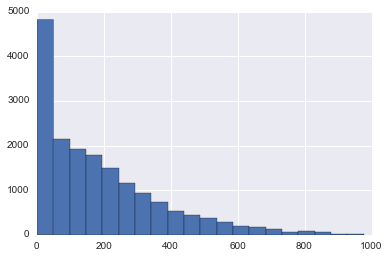

In [5]:
bike_rentals.cnt.hist(bins=20)

Let's look to see how bike rentals correlate to the other columns:

In [6]:
corr = bike_rentals.corr()
corr['cnt']

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

It looks like there are correlations between the hour of the day, the temperature, and humidity (negative). Casual and registered columns don't matter because the rental count is derived from these.

Let's look at how the numerical columns look compared to the rentals. It's intersting to see that there is a negative correlation to holidays. Let's overlay holidays on the plots.

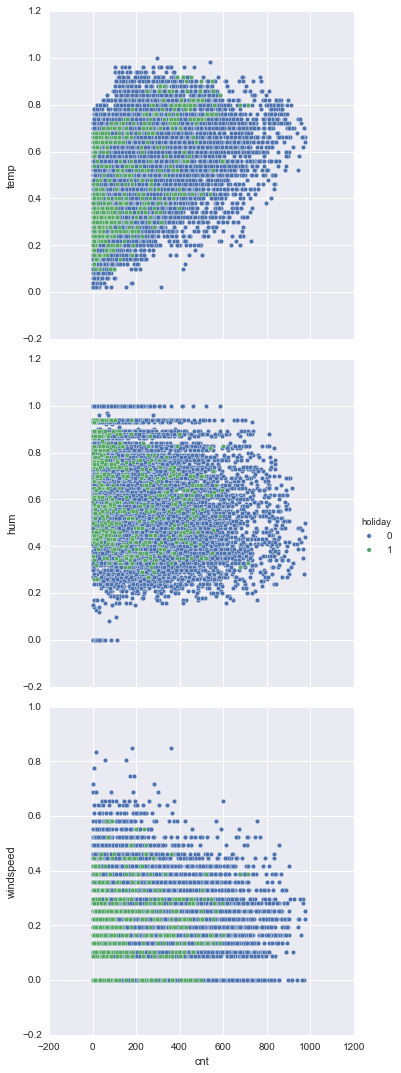

In [7]:
g = sns.pairplot(data=bike_rentals,x_vars=['cnt'], \
             y_vars=['temp','hum', 'windspeed'], size=5,hue='holiday')

Let's look at how `temp` and `atemp` compare to each other

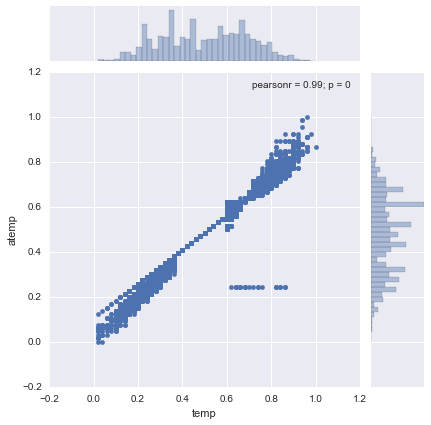

In [8]:
sns.jointplot(x=bike_rentals.temp,y=bike_rentals.atemp)

It looks like the adjusted temp is greater than the actual temperature at higher temps, and lower at lower temps. This is probably taking into account the humidity and wind speed to come up with what the temperature feels like. 

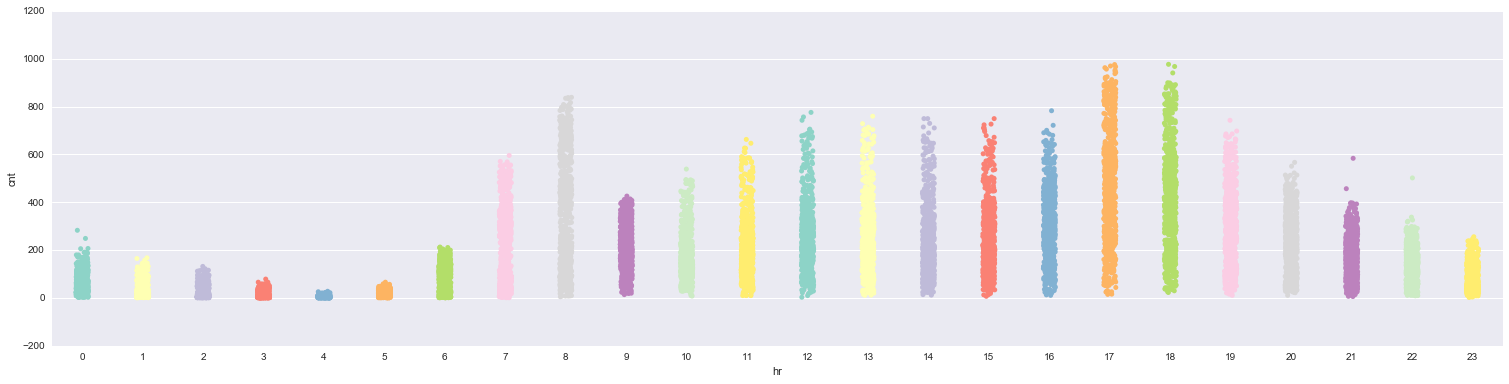

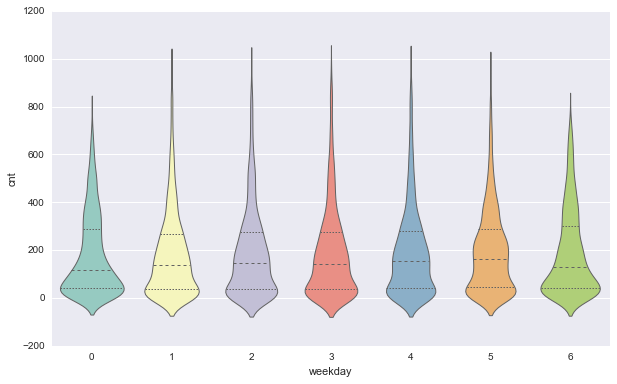

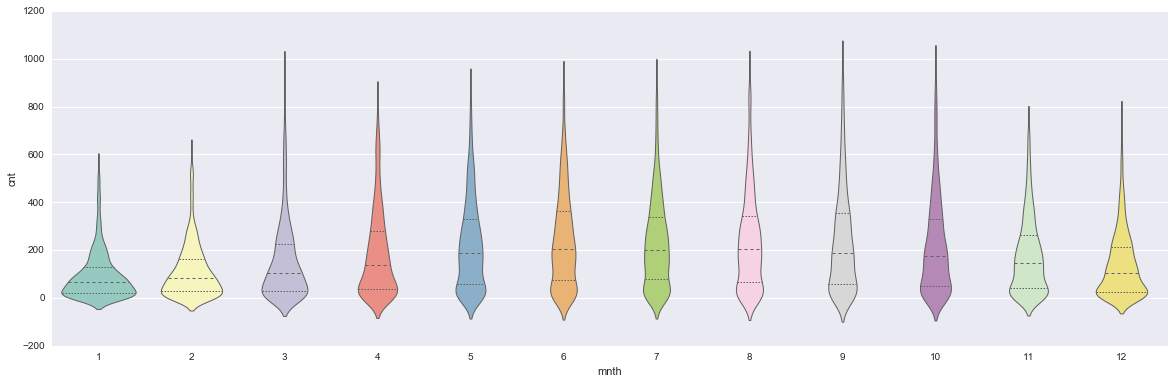

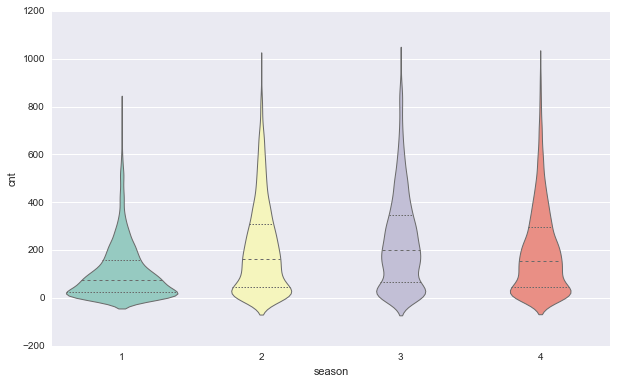

In [9]:
plt.figure(figsize=(26, 6))
sns.stripplot(data=bike_rentals,y='cnt',x='hr',palette="Set3",jitter=True)
plt.show()
plt.figure(figsize=(10, 6))
sns.violinplot(data=bike_rentals,y='cnt',x='weekday',palette="Set3", linewidth=1,inner="quartile")
plt.show()
plt.figure(figsize=(20, 6))
sns.violinplot(data=bike_rentals,y='cnt',x='mnth',palette="Set3", linewidth=1,inner="quartile")
plt.show()
plt.figure(figsize=(10, 6))
sns.violinplot(data=bike_rentals,y='cnt',x='season',palette="Set3", linewidth=1,inner="quartile")
plt.show()

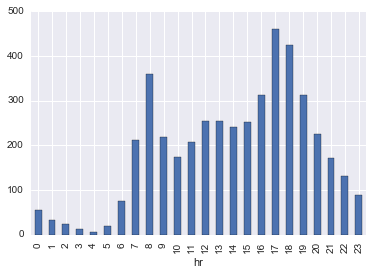

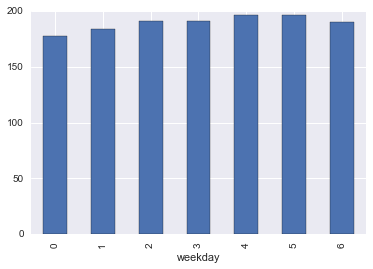

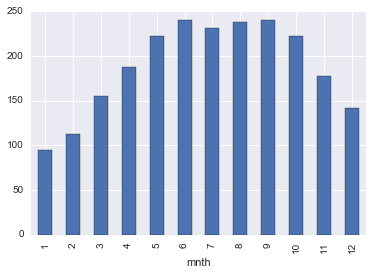

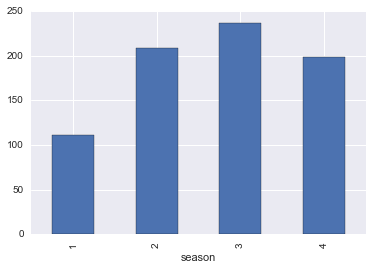

In [10]:
bike_rentals.groupby('hr').agg('mean')['cnt'].plot(kind='bar')
plt.show()
bike_rentals.groupby('weekday').agg('mean')['cnt'].plot(kind='bar')
plt.show()
bike_rentals.groupby('mnth').agg('mean')['cnt'].plot(kind='bar')
plt.show()
bike_rentals.groupby('season').agg('mean')['cnt'].plot(kind='bar')
plt.show()


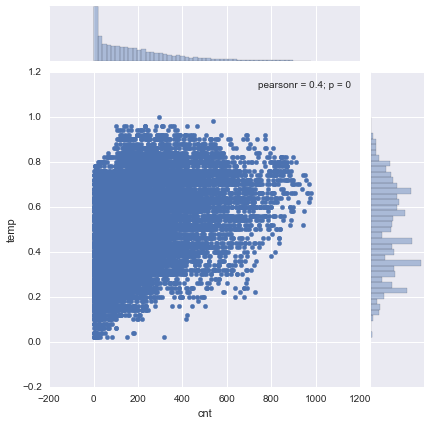

In [11]:
sns.jointplot(data=bike_rentals,x='cnt',y='temp')

Let's look at how registered riders and casual riders compare to one another:

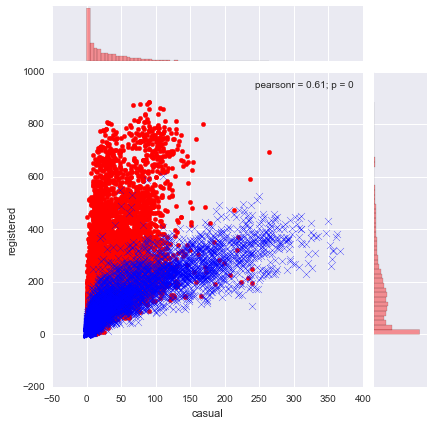

In [12]:
weekend = bike_rentals[bike_rentals.workingday!=1]
weekday = bike_rentals[bike_rentals.workingday==1]

graph = sns.jointplot(data=weekday,x='casual',y='registered',color='r')
graph.x = weekend.casual
graph.y = weekend.registered
graph.plot_joint(plt.scatter, marker='x', c='b', s=50)


It looks like theres a correlations between casual riders on the weekend, and registered riders on weekdays. Let's look in to this more.

In [13]:
bike_rentals[['workingday','casual','registered']].corr()

,workingday,casual,registered
workingday,1.000000,-0.300942,0.134326
casual,-0.300942,1.000000,0.506618
registered,0.134326,0.506618,1.000000


Yep, it looks like there is a negative correlation between the number of casual riders and wether or not it is a working day.

## Variable Selection
Which variables do we want to use in our analysis? And what pre processing is required?

Let's drop the `instant` column since that is just a row label. Let's also drop `dteday` and `yr` since it isn't clear how it will help us. Let's also drop `season` since that data is duplicated in the `mnth` variable. And let's drop the `temp` variable since this is duplicated in the adjusted temp.

In [14]:
bike_rentals.drop(['instant','dteday','yr','season','temp'], inplace=True, axis=1)

In order to simplify the data, let's convert `hr` into 4 separate times of the day, and drop the `hr` variable.

In [15]:
def assign_label(hour):
    if hour < 6:
        val = 4
    elif hour < 12:
        val = 1
    elif hour < 18:
        val = 2
    else:
        val = 3
    return val
bike_rentals['time_label'] = bike_rentals.hr.apply(assign_label)
bike_rentals.drop(['hr'], inplace=True, axis=1)

## Category Variables

It looks like `season`, `hr`, `weekday`, and `weathersit` are categorical. So we will need to convert these to dummy variables. If we don't, our regression algorithm will think Friday is more important than Monday because it treats everything as numerical variables.

In [16]:
cat_cols = ['mnth','time_label','holiday','weekday','weathersit']
for col in cat_cols:
    bike_rentals[col] = bike_rentals[col].astype('category')
dummy_df = pd.get_dummies(bike_rentals[cat_cols])
bike_rentals = pd.concat([bike_rentals,dummy_df],axis=1)
bike_rentals.drop(cat_cols,inplace=True,axis=1)

In [17]:
bike_rentals.columns

Index(['workingday', 'atemp', 'hum', 'windspeed', 'casual', 'registered',
       'cnt', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6',
       'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12',
       'time_label_1', 'time_label_2', 'time_label_3', 'time_label_4',
       'holiday_0', 'holiday_1', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weathersit_1',
       'weathersit_2', 'weathersit_3', 'weathersit_4'],
      dtype='object')

Let's split the dataset into a training and test set:

In [18]:
train = bike_rentals.sample(frac=0.8)
test = bike_rentals[~bike_rentals.index.isin(train.index)]

Let's select which columns we'll use to predict the rental count:

In [19]:
columns = ['atemp', 'hum', 'windspeed', 'mnth_1',\
       'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8',\
       'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12', 'time_label_1',\
       'time_label_2', 'time_label_3', 'time_label_4', 'holiday_0',\
       'holiday_1', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3',\
       'weekday_4', 'weekday_5', 'weekday_6', 'workingday',\
       'weathersit_1', 'weathersit_2', 'weathersit_3', 'weathersit_4']

In [20]:
train[columns]

,atemp,hum,windspeed,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,...,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday,weathersit_1,weathersit_2,weathersit_3,weathersit_4
16637,0.3030,0.81,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0,1.0,0.0,0.0,0.0
6112,0.4545,0.72,0.2239,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0,0.0,1.0,0.0,0.0
4243,0.6818,0.27,0.3582,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1,1.0,0.0,0.0,0.0
16403,0.2879,0.87,0.1045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1,1.0,0.0,0.0,0.0
17184,0.3333,0.42,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0
15383,0.3333,0.87,0.1343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0
14622,0.6667,0.84,0.1642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1,0.0,0.0,1.0,0.0
6533,0.5000,0.68,0.2239,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1,1.0,0.0,0.0,0.0
7172,0.4091,0.50,0.1343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1.0,0.0,0.0,0.0
2685,0.6061,0.73,0.4179,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1,1.0,0.0,0.0,0.0


# Linear Regression
Let's setup a linear regression model based on these inputs.

In [21]:
lr = LinearRegression()
lr.fit(train[columns],train.cnt)
pred = lr.predict(test[columns])

In [22]:
pred

array([ -38. ,  -24.5,  240. , ...,  -38. ,  -54. ,  189.5])

And the mean squared error is.....

In [23]:
MSE = mean_squared_error(test.cnt,pred)
print(MSE)
MAE = mean_absolute_error(test.cnt,pred)
print(MAE)

19380.8789018
100.946993671


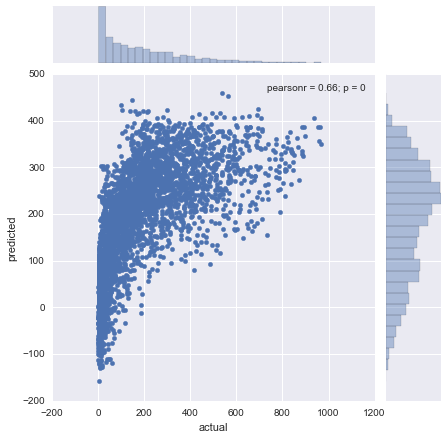

In [24]:
sns.jointplot(x=test.cnt.values, y=pred).set_axis_labels("actual",'predicted')

This graph doesn't look like the predictions are that great...

# Decision Trees
Let's take a look at the Decision Tree Regressor from scikit learn:

Let's create a function that can iterate on the parameters we want to vary.

In [25]:


params = {
    'min_samples_leaf': [3,7,13],
    'max_depth': [None,5, 10, 15],
    'min_samples_split': [15,30,50]
}

from itertools import product
d = {'Color': ['Red', 'Yellow'], 'Size': ['Small', 'Medium', 'Large']}
list_of_params = [dict(zip(params, v)) for v in product(*params.values())]
list_of_params

[{'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 15},
 {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 15},
 {'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 15},
 {'max_depth': 15, 'min_samples_leaf': 3, 'min_samples_split': 15},
 {'max_depth': None, 'min_samples_leaf': 7, 'min_samples_split': 15},
 {'max_depth': 5, 'min_samples_leaf': 7, 'min_samples_split': 15},
 {'max_depth': 10, 'min_samples_leaf': 7, 'min_samples_split': 15},
 {'max_depth': 15, 'min_samples_leaf': 7, 'min_samples_split': 15},
 {'max_depth': None, 'min_samples_leaf': 13, 'min_samples_split': 15},
 {'max_depth': 5, 'min_samples_leaf': 13, 'min_samples_split': 15},
 {'max_depth': 10, 'min_samples_leaf': 13, 'min_samples_split': 15},
 {'max_depth': 15, 'min_samples_leaf': 13, 'min_samples_split': 15},
 {'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 30},
 {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 30},
 {'max_depth': 10, 'min_samples_leaf': 3

Let's create a dataframe to track the results easier

In [26]:
results = pd.DataFrame(list_of_params)
results.head(5)

,max_depth,min_samples_leaf,min_samples_split
0,NaN,3,15
1,5.0,3,15
2,10.0,3,15
3,15.0,3,15
4,NaN,7,15


Now lets use these parameters with the decision tree regressor and look at the mean squared error for the train and test data sets.

In [27]:
dt_results = []
for params in list_of_params:
    model = DecisionTreeRegressor(random_state=1, **params)
    model.fit(train[columns],train.cnt)
    #let's predict the train data and find the error
    pred_train = model.predict(train[columns])
    MSE_train = mean_squared_error(train.cnt,pred_train)

    #lets predict the test data and find the error
    pred_test = model.predict(test[columns])
    MSE_test = mean_squared_error(test.cnt,pred_test)
    
    MSE_diff = MSE_train - MSE_test
    
    d = {
        'dt_MSE_train': MSE_train,
        'dt_MSE_test': MSE_test,
        'dt_MSE_diff': MSE_diff
    }
    dt_results.append(d)
#     print("Case: = {0}".format(params))
#     print("   MSE_train: {0}   MSE_test: {1}  MSE_diff: {2}".\
#           format(np.round(MSE_train,decimals=2),\
#                  np.round(MSE_test,decimals=2),\
#                 np.round(MSE_diff,decimals=2)))
    

In [28]:
results = results.merge(np.round(pd.DataFrame(dt_results),decimals=1),left_index=True,right_index=True)

In [29]:
results

,max_depth,min_samples_leaf,min_samples_split,dt_MSE_diff,dt_MSE_test,dt_MSE_train
0,NaN,3,15,-10360.4,18941.4,8581.0
1,5.0,3,15,-1243.4,18310.7,17067.3
2,10.0,3,15,-3967.8,17085.1,13117.3
3,15.0,3,15,-8317.7,18253.2,9935.6
4,NaN,7,15,-7662.1,17477.8,9815.7
5,5.0,7,15,-1239.8,18308.2,17068.4
6,10.0,7,15,-3477.1,16742.2,13265.0
7,15.0,7,15,-6651.5,17361.0,10709.5
8,NaN,13,15,-5363.4,17090.1,11726.7
9,5.0,13,15,-1241.1,18310.2,17069.2


Let's try to combine the best results:
    `min_samples_leaf = 7`
    `max_depth = 10`
    `min_samples_split = 30`

In [30]:
model = DecisionTreeRegressor(random_state=1, min_samples_split=15,max_depth=15,min_samples_leaf=7)
model.fit(train[columns],train.cnt)
#let's predict the train data and find the error
pred_train = model.predict(train[columns])
MSE_train = mean_squared_error(train.cnt,pred_train)

#lets predict the test data and find the error
pred_test = model.predict(test[columns])
MSE_test = mean_squared_error(test.cnt,pred_test)
print("   MSE_train: {0}   MSE_test: {1}".format(np.round(MSE_train,decimals=2),\
                                                 np.round(MSE_test,decimals=2)))

   MSE_train: 10709.55   MSE_test: 17361.0


# Random Forests
Now let's look at Random Forests:

In [31]:
rf_results = []
for params in list_of_params:
    model = RandomForestRegressor(random_state=1, **params)
    model.fit(train[columns],train.cnt)
    #let's predict the train data and find the error
    pred_train = model.predict(train[columns])
    MSE_train = mean_squared_error(train.cnt,pred_train)

    #lets predict the test data and find the error
    pred_test = model.predict(test[columns])
    MSE_test = mean_squared_error(test.cnt,pred_test)
    
    MSE_diff = MSE_train - MSE_test
    
    d = {
        'rf_MSE_train': MSE_train,
        'rf_MSE_test': MSE_test,
        'rf_MSE_diff': MSE_diff
    }
    rf_results.append(d)

In [32]:
results = results.merge(np.round(pd.DataFrame(rf_results),decimals=1),\
                        left_index=True,right_index=True)

How does the Random forest results compare to the decision tree results?

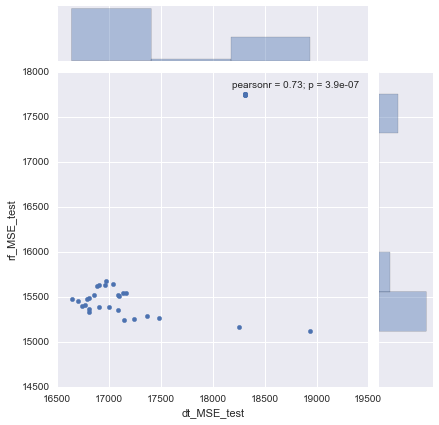

In [33]:
sns.jointplot(x=results.dt_MSE_test,y=results.rf_MSE_test)

It looks like there's some of the results which have high error. Let's see which params cause that.

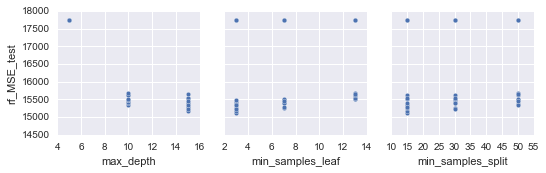

In [34]:
sns.pairplot(results,x_vars=['max_depth','min_samples_leaf',\
                             'min_samples_split'],y_vars=['rf_MSE_test'])

Yep it looks like it's due to the `max_depth` parameter. Let's take a closer look:

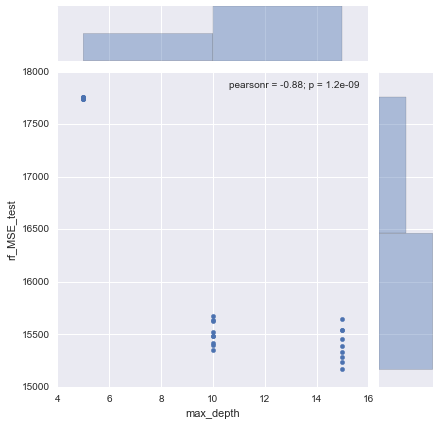

In [35]:
sns.jointplot(x='max_depth',y='rf_MSE_test',data=results)

It looks like there is a large reduction in error between `max_depth=5` and `max_depth=10`. Now that we know this, let's not use `max_depth=5`

In [36]:

params = {
    'min_samples_leaf': [3,7,13],
    'max_depth': [None,10, 15],
    'min_samples_split': [15,30,50]
}

from itertools import product
list_of_params = [dict(zip(params, v)) for v in product(*params.values())]


## Predictions for casual riders

In [37]:
cas_results = pd.DataFrame(list_of_params)

In [38]:
rf_results = []
for params in list_of_params:
    model = RandomForestRegressor(random_state=1, **params)
    model.fit(train[columns],train.casual)
    #let's predict the train data and find the error
    pred_train = model.predict(train[columns])
    MSE_train = mean_squared_error(train.casual,pred_train)

    #lets predict the test data and find the error
    pred_test = model.predict(test[columns])
    MSE_test = mean_squared_error(test.casual,pred_test)
    
    MSE_diff = MSE_train - MSE_test
    
    d = {
        'rf_MSE_train': MSE_train,
        'rf_MSE_test': MSE_test,
        'rf_MSE_diff': MSE_diff
    }
    rf_results.append(d)

In [39]:
cas_results = cas_results.merge(np.round(pd.DataFrame(rf_results),decimals=1),\
                                left_index=True,right_index=True)

In [40]:
cas_results

,max_depth,min_samples_leaf,min_samples_split,rf_MSE_diff,rf_MSE_test,rf_MSE_train
0,NaN,3,15,-199.1,489.9,290.8
1,10.0,3,15,-137.1,520.4,383.3
2,15.0,3,15,-188.9,490.1,301.2
3,NaN,7,15,-163.8,506.3,342.4
4,10.0,7,15,-123.9,527.4,403.5
5,15.0,7,15,-159.3,505.8,346.5
6,NaN,13,15,-107.6,543.1,435.5
7,10.0,13,15,-93.3,552.5,459.2
8,15.0,13,15,-106.9,543.1,436.2
9,NaN,3,30,-132.7,508.4,375.7


## Predictions for registered riders

In [41]:
reg_results = pd.DataFrame(list_of_params)
rf_results = []
for params in list_of_params:
    model = RandomForestRegressor(random_state=1, **params)
    model.fit(train[columns],train.registered)
    #let's predict the train data and find the error
    pred_train = model.predict(train[columns])
    MSE_train = mean_squared_error(train.registered,pred_train)

    #lets predict the test data and find the error
    pred_test = model.predict(test[columns])
    MSE_test = mean_squared_error(test.registered,pred_test)
    
    MSE_diff = MSE_train - MSE_test
    
    d = {
        'rf_MSE_train': MSE_train,
        'rf_MSE_test': MSE_test,
        'rf_MSE_diff': MSE_diff
    }
    rf_results.append(d)

reg_results = reg_results.merge(np.round(pd.DataFrame(rf_results),decimals=1),left_index=True,right_index=True)

In [42]:
reg_results

,max_depth,min_samples_leaf,min_samples_split,rf_MSE_diff,rf_MSE_test,rf_MSE_train
0,NaN,3,15,-5301.5,12426.6,7125.1
1,10.0,3,15,-2568.0,12518.0,9950.0
2,15.0,3,15,-4574.3,12378.9,7804.7
3,NaN,7,15,-4560.3,12589.4,8029.1
4,10.0,7,15,-2497.0,12589.6,10092.6
5,15.0,7,15,-4156.9,12577.6,8420.8
6,NaN,13,15,-3337.6,12713.7,9376.0
7,10.0,13,15,-2316.2,12737.8,10421.6
8,15.0,13,15,-3208.9,12707.8,9498.9
9,NaN,3,30,-3880.8,12425.9,8545.1


So it looks like the error for the casual riders and registered riders is smaller than the error for the overall rentals. I wonder if we can predict the casual and registered seperatly and combine the results to get better predictions than before?

First, lets look at the errors and compare them.

## Combined Predictions

In [43]:
combined_MSE_test = cas_results.rf_MSE_test + reg_results.rf_MSE_test
np.mean(combined_MSE_test - results.rf_MSE_test)

-2866.3629629629627

In [44]:
model = RandomForestRegressor(random_state=1, max_depth=15,\
                                  min_samples_leaf=3, min_samples_split=15)
model.fit(train[columns],train.cnt)
#let's predict the train data and find the error
cnt_pred_train = model.predict(train[columns])
cnt_MSE_train = mean_squared_error(train.cnt,cnt_pred_train)

#lets predict the test data and find the error
cnt_pred_test = model.predict(test[columns])
cnt_MSE_test = mean_squared_error(test.cnt,cnt_pred_test)
cnt_MSE_diff = cnt_MSE_train - cnt_MSE_test
print(cnt_MSE_test)


15165.1113252


490.111523008


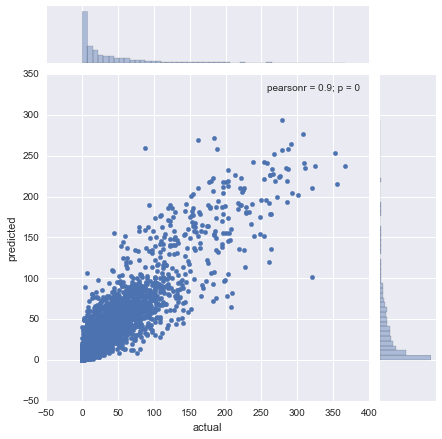

In [45]:
model = RandomForestRegressor(random_state=1, max_depth=15,\
                                  min_samples_leaf=3, min_samples_split=15)
model.fit(train[columns],train.casual)
#let's predict the train data and find the error
cas_pred_train = model.predict(train[columns])
cas_MSE_train = mean_squared_error(train.casual,cas_pred_train)

#lets predict the test data and find the error
cas_pred_test = model.predict(test[columns])
cas_MSE_test = mean_squared_error(test.casual,cas_pred_test)
cas_MSE_diff = cas_MSE_train - cas_MSE_test
print(cas_MSE_test)
sns.jointplot(x=test.casual.values,y=cas_pred_test).set_axis_labels("actual",'predicted')

12378.938143


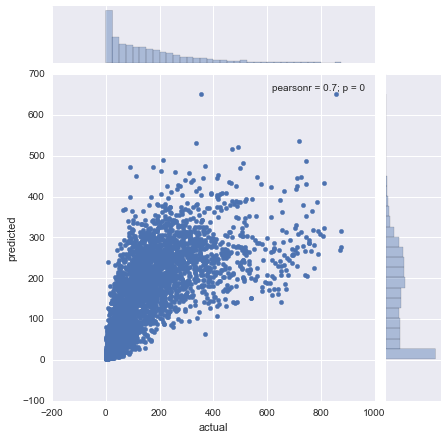

In [46]:
model = RandomForestRegressor(random_state=1, max_depth=15,\
                                  min_samples_leaf=3, min_samples_split=15)
model.fit(train[columns],train.registered)
#let's predict the train data and find the error
reg_pred_train = model.predict(train[columns])
reg_MSE_train = mean_squared_error(train.registered,reg_pred_train)

#lets predict the test data and find the error
reg_pred_test = model.predict(test[columns])
reg_MSE_test = mean_squared_error(test.registered,reg_pred_test)
reg_MSE_diff = reg_MSE_train - reg_MSE_test
print(reg_MSE_test)
sns.jointplot(x=test.registered.values, y=reg_pred_test).set_axis_labels("actual",'predicted')

In [47]:
comb_pred_test = cas_pred_test + reg_pred_test
comb_MSE_test = mean_squared_error(test.cnt,comb_pred_test)
print("Combined error: {0}".format(comb_MSE_test))
print("Regular error: {0}".format(cnt_MSE_test))

Combined error: 14715.213704404714
Regular error: 15165.111325233434


So it looks like creating two separate predictions and combining them doesn't reduce the error!

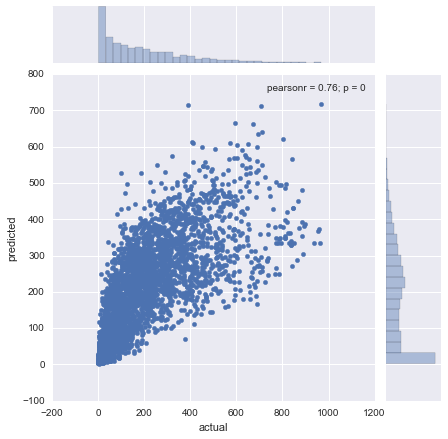

In [48]:
sns.jointplot(x=test.cnt.values, y=comb_pred_test).set_axis_labels("actual",'predicted')

Ok, the predictions looks pretty good, but the R value is only 0.76. Let's try Neural Networks next.

# Neural Networks:
TBD